In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   --> src/ladder_filter.rs:131:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
131 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

 --> src/mverb.rs:8:10
  |
8 | pub enum MVerbParam {
  |          ^^^^^^^^^^

    Finished dev [unoptimized + debuginfo] target(s) in 0.02s
📦 Built wheel for CPython 3.10 to /tmp/.tmpGIfTid/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR, LowPassFilter, SquareOscillator, Reverb
from IPython.display import Audio, display, Image, HTML
from luthier.dsp import Sample, SAMPLE_RATE
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import differential_evolution
import numpy as np
from IPython.display import clear_output

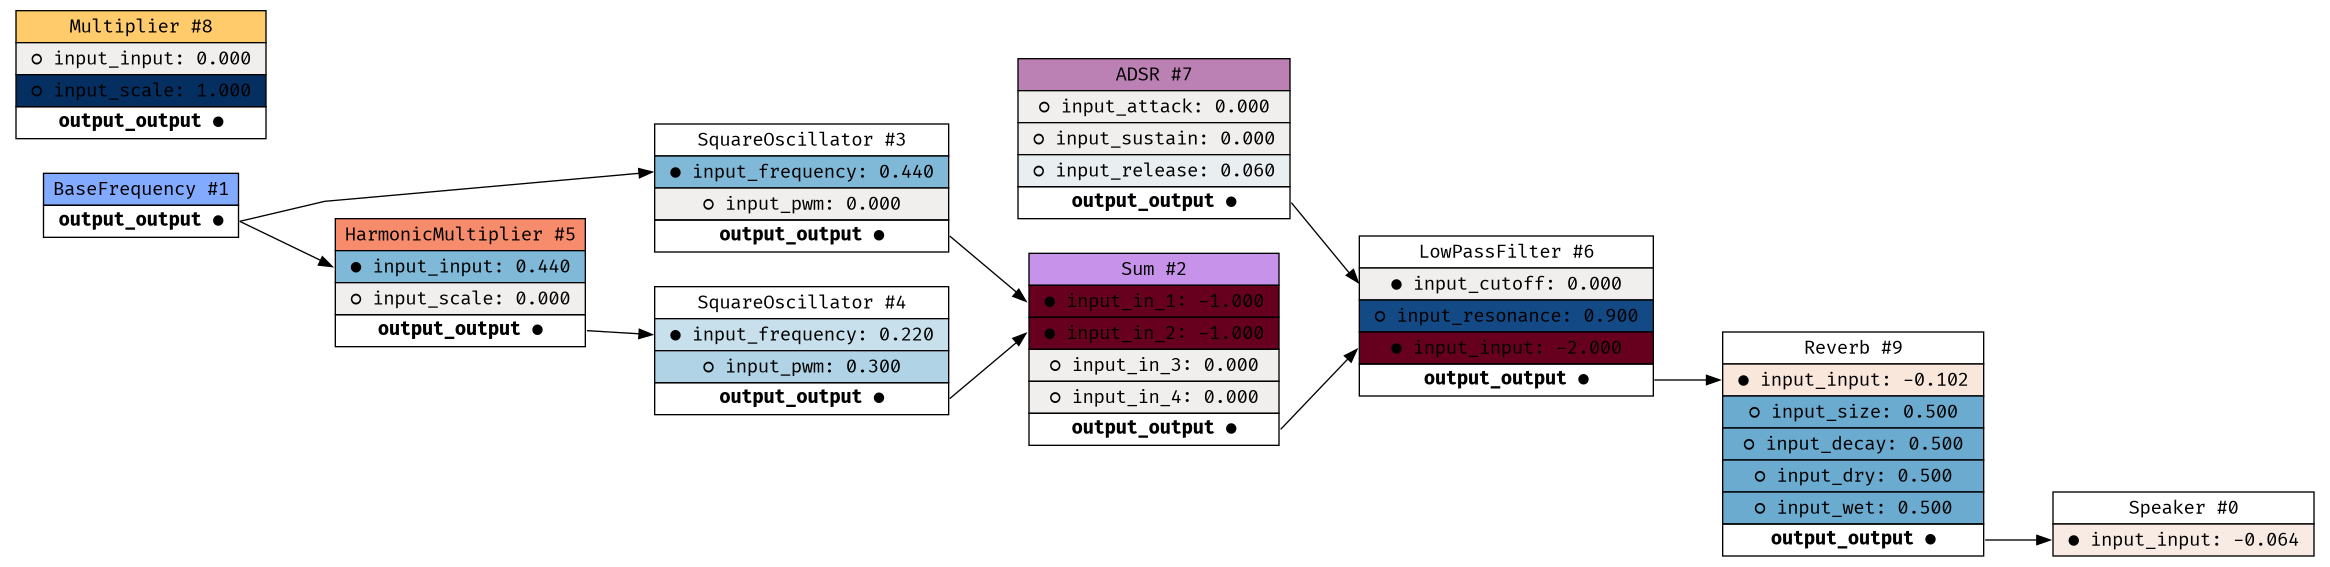

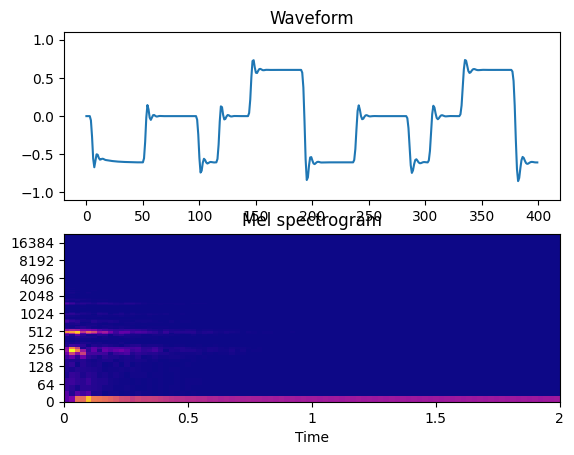

In [23]:
def square_analog():
    graph = DspGraph()

    mixer = graph.add_sum(Sum())

    s = SquareOscillator()
    s.input_pwm = 0.0
    s = graph.add_square(s)

    s2 = SquareOscillator()
    s2.input_pwm = 0.3

    s2 = graph.add_square(s2)

    osc2_mult = HarmonicMultiplier()

    osc2_mult = graph.add_harmonic_multiplier(osc2_mult)

    graph.patch(graph.base_frequency_node_id, "output_output", osc2_mult, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", s, "input_frequency")
    graph.patch(osc2_mult, "output_output", s2, "input_frequency")
    graph.patch(s2, "output_output", mixer, "input_in_2")
    graph.patch(s, "output_output", mixer, "input_in_1")

    f = LowPassFilter()
    f = graph.add_lowpass(f)

    filter_adsr = ADSR()
    filter_adsr.input_attack = 0.0
    filter_adsr.input_sustain = 0.0
    filter_adsr.input_release = 0.06
    filter_adsr = graph.add_adsr(filter_adsr)
    graph.patch(filter_adsr, "output_output",  f, "input_cutoff")

    osc_mult = Multiplier()
    osc_mult.input_scale = 1.0
    osc_mult = graph.add_multiplier(osc_mult)

    r = Reverb()
    r = graph.add_reverb(r)

    graph.patch(mixer, "output_output", f, "input_input")
    graph.patch(f, "output_output", r, "input_input")
    graph.patch(r, "output_output", graph.speaker_node_id, "input_input")

    graph.set_input(f, "input_resonance", 0.9)
    
    return graph

graph = square_analog()

audio = Sample(graph.play(SAMPLE_RATE*2))
target_sample = audio
display(Image(graph.draw()))

fig, (ax, ax2) = plt.subplots(2)
audio.plot_waveform(ax)
audio.plot_spectrogram(ax2)
audio.show_player()

plt.show()

In [ ]:
# target_audio = fm_sample

MAX_ITERATIONS = 15
POPULATION_SIZE = 60

def optimise_freq_and_mod(x):
    graph = square_analog()
    graph.set_inputs(x)
    generated_audio = Sample(graph.play(len(target_audio)))
    dist = target_audio.mfcc_distance(generated_audio)
    
    return dist

def show_comparison(x):
    graph = square_analog()
    graph.set_inputs(x)

    generated_audio = Sample(graph.play(num_samples = SAMPLE_RATE * 1))
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

    generated_audio.show_player()
    target_audio.show_player()

    generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
    generated_audio.plot_waveform(ax5, title="Trained waveform")
    generated_audio.plot_mfcc(ax3, title="Trained MFCC")

    target_audio.plot_spectrogram(ax2, title="Target spectrogram")
    target_audio.plot_waveform(ax6, title="Target waveform")
    target_audio.plot_mfcc(ax4, title="Target MFCC")

    fig.tight_layout()
    # plt.savefig(f'{time.time()}.png')
    plt.show()

target_fun_values = []
def callback(x, convergence):
    target_fun = square_analog(x)
    target_fun_values.append(target_fun)
    clear_output()
    show_comparison(x)
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = one_operator_fm().num_inputs()
print("Solving for num inputs", num_params)
solution = differential_evolution(
    optimise_freq_and_mod,
    [ (-1, 1) for i in range(num_params) ],
    workers=8,
    maxiter=MAX_ITERATIONS,
    popsize=POPULATION_SIZE,
    polish=False,
    disp=False,
    callback=callback
)
print(solution)